In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyedflib as el
from datetime import datetime, timedelta
from matplotlib import pyplot as pp
import seaborn as sns
pp.rcParams['figure.figsize'] = (16.0, 8.0)

30.07.2016, Pawel [alxd](https://alxd.org/) Chojnacki
# NeuroOn Hypnogram Analysis

Following my principles of Open Access and Open Notebook Science I'd like to present you my comparative analysis of NeuroOn and a professional polisomnograph recording from two nights. To learn more about the experiment itself, please head back to my [previous blog post](https://alxd.org/neuroon-analysis-sources.html).

*[more on NeuroOn and AURA PSG, make assumption that Aura is the closest thing to what is actually happening in the brain]*

At the moment of writing this I haven't been professionally involved in EEG analysis for over two years - please feel free to comment on my code and let me know if any part is unclear or may lead to wrong conclusions.

## Signal formats

All signals are available for download [here](https://obsidian.alxd.org/cloud/index.php/s/GvTLhgL8A7I8iTF), with md5sum `2ed8faecb52e027948f19d62175e02da`.

NeuroOn signal was obtained by using proprietary Intelclinic's scripts I am not allowed to share. They produced four CSV files, containing respectively:

 - EEG signal (125 Hz)
 - accelerometer signal
 - LED activity
 - Staging ([hypnogram](https://en.wikipedia.org/wiki/Hypnogram))

AURA PSG signal was exported to an EDF format using Grass Technologies PSG TWin 4.5.4 and 4.5.2 to minimize the risk of software-derived artifacts. The channels signals include:

 - EOG1-A1
 - EOG2-A1
 - CHIN1-CHIN2
 - CHIN2-CHIN3
 - F3-A2
 - C3-A2
 - O1-A2
 - F4-A1
 - C4-A1
 - O2-A1
 - SNORE (first night only)
 - FLOW (first night only)
 - CHEST (first night only)
 - ABDOMEN (first night only)
 - ECG (first night only)
 - SaO2 (blood oxygen saturation, first night only)
 - HR (heart rate, first night only)
 - LEG1 (first night only)
 - LEG2 (first night only)
 - Pos (first night only)

PSG signals from both nights were scored by a professional and exported to XLS and CSV files.

Since proper comparative analysis of NeuroOn's and AURA's signals would require an immense amount of work, I'd like to start with comparing their hypnograms.

## Time synchronisation

Hypnogram comparison requires us to synchronise signals from both devices in time. With NeuroOn operating in debug mode there was no way I know of to place markers, leaving us with no easy way to sync. To counter that, for the first several minutes of PSG recording I repeatedly clenched my jaw and moved my eyebrows to introduce muscle artifacts to both signals, allowing me to synchronise both afterwards.

Luckily, the latest version of software I was given by Intelclinic supports recovering timestamps from the device, which could make the whole undertaking a lot easier. It should be enough to:

 - find the initial timestamps of both signals
 - [tests - autocorrelation, correlation in time]
 - visualize them
 - adjust or remove hypnogram datapoints outside of common recording time

At this point it's important to remember that the devices recorded signal with different sampling rate, `125 Hz` for NeuroOn and `200 Hz` for AURA.

In [2]:
# first, open the AURA signal file from the first night
edf_file = el.EdfReader('night_01/psg_signal.edf')

In [3]:
# now open NeuroOn signal file
neuroon_signal = pd.read_csv('night_01/neuroon_signal.csv')
# print(neuroon_signal['timestamp'][0])
neuroon_signal['timestamp'] = neuroon_signal['timestamp'].astype(int)
neuroon_signal['timestamp'] = pd.to_datetime(neuroon_signal['timestamp'], unit='ms')
# account for 2h shift
neuroon_signal['timestamp'] += timedelta(hours=2)
# now in nanoVolts, scale to microVolts
neuroon_signal['signal'] = neuroon_signal['signal'] / 1000.
neuroon_signal[:5]

timestamp  signal
0 2016-06-20 22:01:00.000 -32.768
1 2016-06-20 22:01:00.008 -32.768
2 2016-06-20 22:01:00.016 -32.768
3 2016-06-20 22:01:00.024 -32.768
4 2016-06-20 22:01:00.032 -32.768

In [4]:
# read respective starting timestamps

psg_start = edf_file.getStartdatetime()
print('PSG recording started', psg_start)

neuroon_start = neuroon_signal['timestamp'][0]
print('NeuroOn recording started', neuroon_start)

PSG recording started 2016-06-20 22:29:48
NeuroOn recording started 2016-06-20 22:01:00


Which suggests that if NeuroOn timestamps are right, it started recording about 28 minutes before the PSG - just after being programmed via the debugger. This is not the only possibility however - we should also check if the signal gathered at the same timestamps corresponds to the signal from the closest PSG electrode - `EOG1-A1`.

In [5]:
# NeuroOn sampling rate was specified to be 125 Hz, but let's check

NEUROON_SAMPLE_RATE = len(neuroon_signal[
    neuroon_signal['timestamp'] < neuroon_signal['timestamp'][0] + timedelta(seconds=1)
])
print('NeuroOn sample rate is', NEUROON_SAMPLE_RATE)

seconds_between_startdates = psg_start - neuroon_start
print('We need to adjust the NeuroOn signal', seconds_between_startdates)

no_shifted_signal = neuroon_signal[neuroon_signal['timestamp'] > psg_start]
no_shifted_signal = no_shifted_signal.reset_index(drop=True)

time_difference_us = (no_shifted_signal['timestamp'][0] - psg_start).microseconds

print('Timestamps are within', time_difference_us, 'microseconds from each other')

NeuroOn sample rate is 125
We need to adjust the NeuroOn signal 0 days 00:28:48
Timestamps are within 8000 microseconds from each other


Now we can visualize first 10 seconds of each signal to get a visual overview - and run some tests to check if the signals correlate.

In [6]:
# let's get EOG1-A1 signal
# edf_file.getPhysicalDimension(0) # uV - microVolts
# 

PSG_SAMPLE_RATE = edf_file.getSampleFrequency(0)

print(edf_file.getLabel(0))
psg_signal = pd.DataFrame(edf_file.readSignal(0), columns=['signal'])
psg_signal['timestamp'] = [
    psg_start + timedelta(milliseconds=(i * (1000/PSG_SAMPLE_RATE)))
    for i in np.arange(len(psg_signal))
]

psg_signal[:5]

b'EOG1-A1'


signal               timestamp
0     -12 2016-06-20 22:29:48.000
1       9 2016-06-20 22:29:48.005
2      31 2016-06-20 22:29:48.010
3      41 2016-06-20 22:29:48.015
4      43 2016-06-20 22:29:48.020

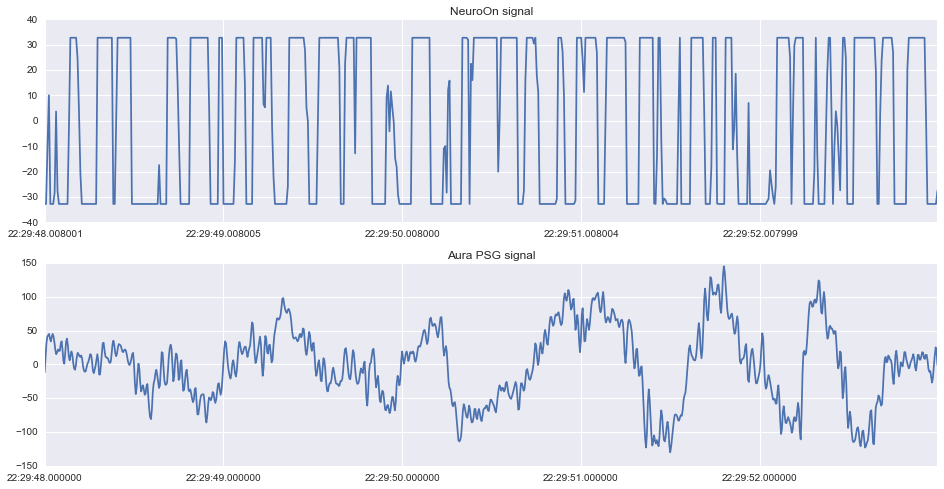

In [7]:
def plot_signal_fragment(
    csv_sig, edf_sig, seconds=10, shift=0,
    csv_title='NeuroOn signal',
    edf_title='Aura PSG signal'
):
    plotting_series = [
        [211, csv_title, csv_sig],
        [212, edf_title, edf_sig]
    ]
    for series in plotting_series:
        pp.subplot(series[0])
        pp.title(series[1])
        signal = series[2]
        time_slice = np.logical_and(
            signal['timestamp'] >= signal['timestamp'][0] + timedelta(seconds=shift),
            signal['timestamp'] < signal['timestamp'][0] + timedelta(seconds=shift + seconds)
        )
        x_axis = signal['timestamp'][time_slice]
        y_axis = signal['signal'][time_slice]
        pp.plot(x_axis, y_axis)
    return pp.show()

plot_signal_fragment(
    no_shifted_signal, psg_signal, seconds=5
)

It seems that NeuroOn cannot handle all the muscle artifacts from the very first minutes of the experiment. Let's try to shift it 10 minutes and see if the signal makes sense then.

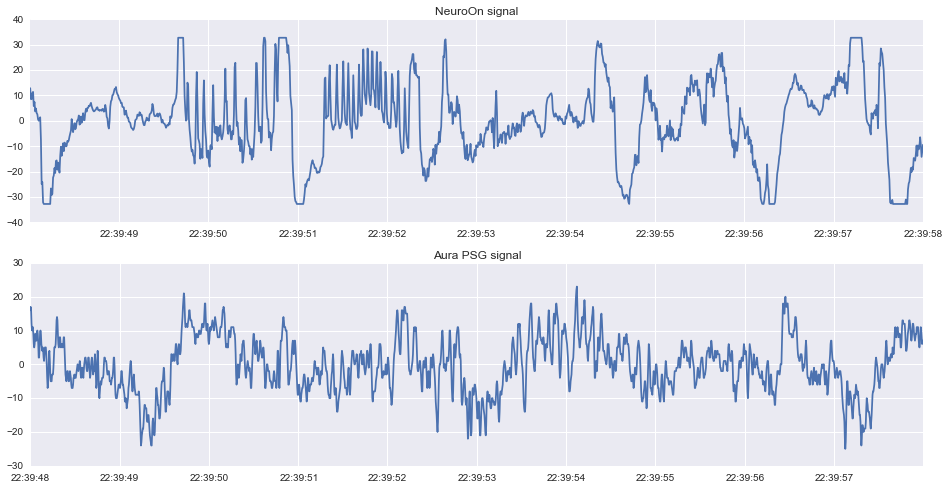

In [8]:
plot_signal_fragment(
    no_shifted_signal, psg_signal,
    shift=600
)

While much clearer, NeuroOn's signal doesn't look similar to Aura's. We shouldn't trust just naked eye (amplitude/time) comparisons, let's try [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) analysis (frequency/time).

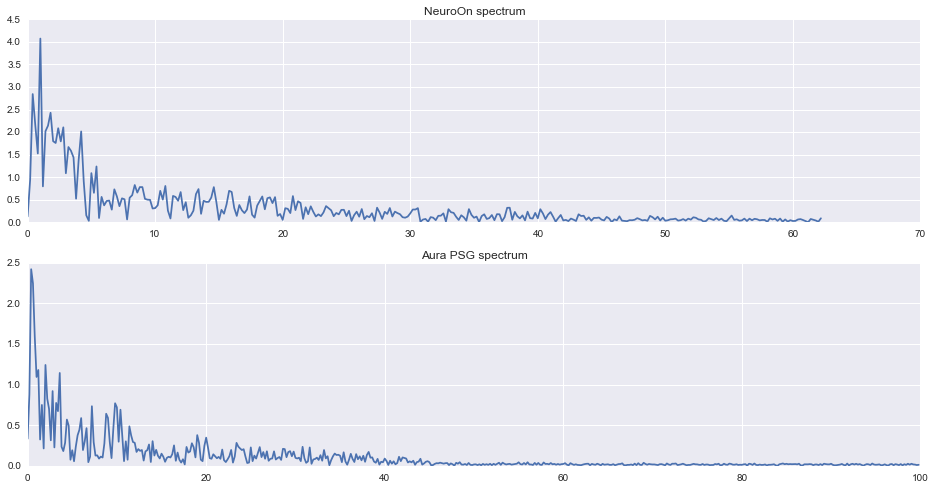

In [9]:
# may be useful to refactor this to share less code with plot_signal_fragment

# TODO: Use pandas

def plot_spectrum_fragment(
    csv_sig, edf_sig, seconds=10, shift=0,
    cap_frequency=False,
    csv_title='NeuroOn spectrum',
    edf_title='Aura PSG spectrum'
):
    plotting_series = [
        [211, csv_title, csv_sig],
        [212, edf_title, edf_sig]
    ]
    for series in plotting_series:
        pp.subplot(series[0])
        pp.title(series[1])
        signal = series[2]
        signal_freq = len(signal[
            signal['timestamp'] < signal['timestamp'][0] + timedelta(seconds=1)
        ])
        time_slice = np.logical_and(
            signal['timestamp'] >= signal['timestamp'][0] + timedelta(seconds=shift),
            signal['timestamp'] < signal['timestamp'][0] + timedelta(seconds=shift + seconds)
        )
        signal_len = len(signal[time_slice])
        signal_y = signal[time_slice]['signal']
        spectrum_y = np.fft.fft(signal_y) / signal_len
        spectrum_x = np.arange(signal_len) / (signal_len / signal_freq)
        half_spectrum = int(signal_len / 2)
        x_axis = spectrum_x[:half_spectrum]
        y_axis = abs(spectrum_y[:half_spectrum])
        if (cap_frequency):
            pp.xlim(0, cap_frequency)
        pp.plot(x_axis, y_axis)
    pp.show()

plot_spectrum_fragment(
    no_shifted_signal, psg_signal, seconds=5,
    shift=600
)

NeuroOn signal is noisy, let's try too zoom at the first 40Hz of the spectrum.

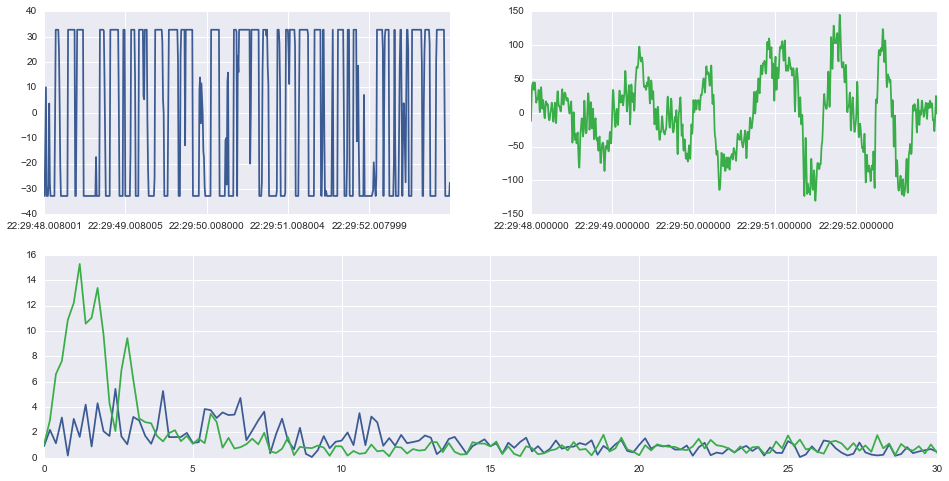

In [10]:
# plot two signals on separate, and both spectrums on single graph
# todo: clean it up

def plot_spectrum_fragment(
    csv_sig, edf_sig, seconds=10, shift=0,
    cap_frequency=False,
    csv_title='NeuroOn spectrum',
    edf_title='Aura PSG spectrum'
):
    plotting_series = [
        [223, csv_title, csv_sig, sns.xkcd_rgb['denim blue']],
        [223, edf_title, edf_sig, sns.xkcd_rgb['medium green']]
    ]
    signal_subplot = 221
    for series in plotting_series:
        pp.subplot(signal_subplot)
#         pp.title(series[1])
        signal = series[2]
        color = series[3]
        signal_freq = len(signal[
            signal['timestamp'] < signal['timestamp'][0] + timedelta(seconds=1)
        ])
        time_slice = np.logical_and(
            signal['timestamp'] >= signal['timestamp'][0] + timedelta(seconds=shift),
            signal['timestamp'] < signal['timestamp'][0] + timedelta(seconds=shift + seconds)
        )
        signal_len = len(signal[time_slice])
        signal_y = signal[time_slice]['signal']
        signal_x = signal[time_slice]['timestamp']
        pp.plot(signal_x, signal_y, color)
        signal_subplot += 1
        pp.subplot(212)
        spectrum_y = np.fft.fft(signal_y) / signal_len
        spectrum_x = np.arange(signal_len) / (signal_len / signal_freq)
        half_spectrum = int(signal_len / 2)
        x_axis = spectrum_x[:half_spectrum]
        y_axis = abs(spectrum_y[:half_spectrum])
        if (cap_frequency):
            pp.xlim(0, cap_frequency)
        pp.plot(x_axis, y_axis, color)
    pp.show()
    
plot_spectrum_fragment(
    no_shifted_signal, psg_signal, seconds=5,
    shift=0, cap_frequency=30
)

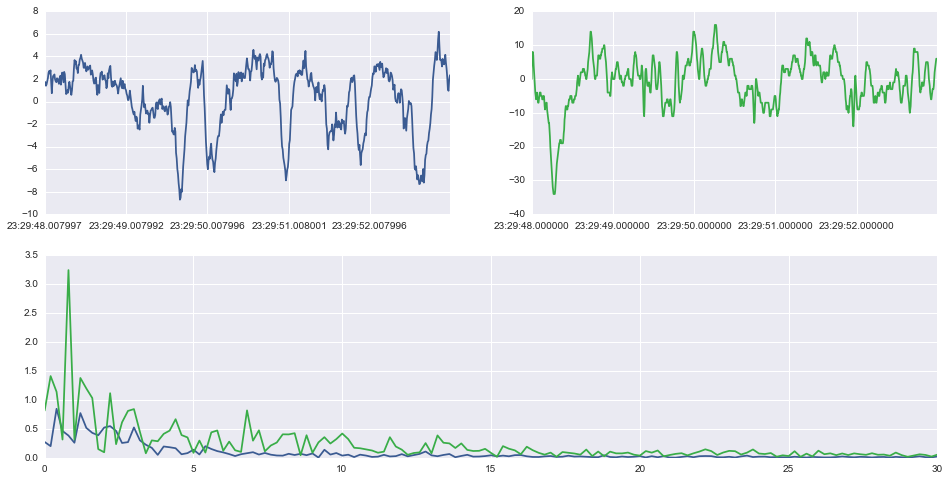

In [11]:
plot_spectrum_fragment(
    no_shifted_signal, psg_signal, seconds=5,
    shift=3600, cap_frequency=30
)

This looks very different, NeuroOn signal is much more scattered all along the spectrum even without muscle artifacts around. I'd love to see some proper spectrograms of both signals.

**TODO**:
 - https://stats.stackexchange.com/questions/31666/how-can-i-align-synchronize-two-signals
 - https://stats.stackexchange.com/questions/16121/for-two-offset-sampled-data-series-what-is-the-best-estimate-of-the-offset-betw/16280#16280
 - make more use of Seaborn
 - [windowing](https://en.wikipedia.org/wiki/Window_function)
 - [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
 - correlation in time (maybe the timestamps aren't correct)
 
 
**ONLY DIRTY NOTES BELOW**

In [12]:
# And now something totally different
# Let's get the staging

neuroon_stages = pd.read_csv('night_01/neuroon_stages.csv')
neuroon_stages.drop('Unnamed: 0', 1, inplace=True)
neuroon_stages['timestamp'] = neuroon_stages['timestamp'].astype(int)
neuroon_stages['timestamp'] = pd.to_datetime(neuroon_stages['timestamp'], unit='ms')
neuroon_stages['timestamp'] += timedelta(hours=2)
neuroon_stages[:10]

stage           timestamp
0      0 2016-06-20 22:01:30
1      0 2016-06-20 22:02:00
2      0 2016-06-20 22:02:30
3      0 2016-06-20 22:03:00
4      0 2016-06-20 22:03:30
5      0 2016-06-20 22:04:00
6      0 2016-06-20 22:04:30
7      0 2016-06-20 22:05:00
8      0 2016-06-20 22:05:30
9      0 2016-06-20 22:06:00

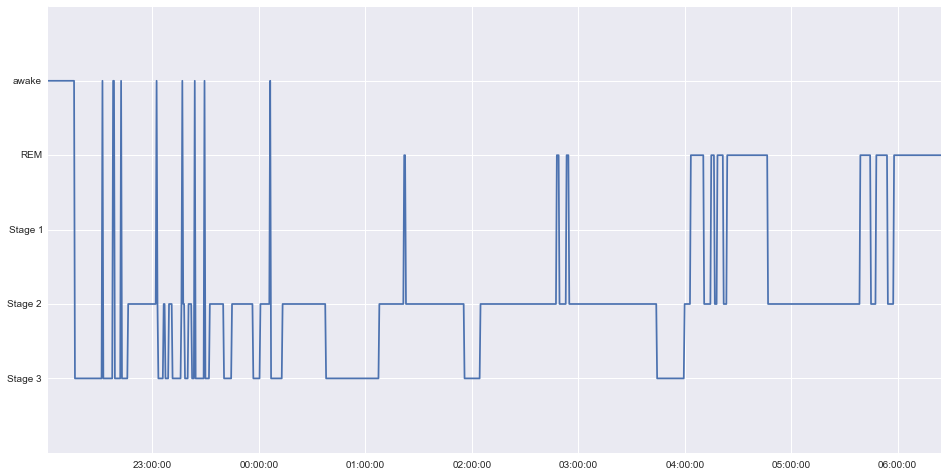

In [13]:
# plotting NeuroOn's stages

pp.plot(neuroon_stages['timestamp'], neuroon_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [14]:
# get signal from PSG

psg_stages = pd.read_csv('night_01/psg_stages.csv', names=['timestamp', 'raw'])
psg_stages['timestamp'] = psg_stages['timestamp']
psg_stages['timestamp'] = pd.to_datetime(psg_stages['timestamp'], format=' %H:%M:%S.%f')
psg_stages[:10]

# clear the data!

timestamp                     raw
0 1900-01-01 22:29:01.000         Start Recording
1 1900-01-01 22:29:01.000  Nowy montaż - 1-PSG-A1
2 1900-01-01 22:29:36.000                  Paused
3 1900-01-01 22:29:48.000         Start Recording
4 1900-01-01 22:29:48.000        Stage - No Stage
5 1900-01-01 22:31:32.500        Kalibracja Start
6 1900-01-01 22:31:48.700            Oczy otwarte
7 1900-01-01 22:31:54.900             Oczy w górę
8 1900-01-01 22:31:59.700              Oczy w dół
9 1900-01-01 22:32:03.100             Oczy w lewo

In [15]:
# fix the date problem, it will be painful for plotting
def split_days(timestamp):
    stage_timedelta = datetime(year=2016, month=6, day=20) - datetime(year=1900, month=1, day=1)
    if timestamp.hour > 12:
        return timestamp + stage_timedelta
    else:
        return timestamp + stage_timedelta + timedelta(days=1)

psg_stages['timestamp'] = psg_stages['timestamp'].apply(split_days)

In [16]:
def clear_psg_stages(stage_desc):
    return {
        'Stage - W': 0,
        'Stage - R': -1,
        'Stage - N1': -2,
        'Stage - N2': -3,
        'Stage - N3': -4,
    }.get(stage_desc, 1)

psg_stages['stage'] = psg_stages['raw'].apply(clear_psg_stages)
psg_stages[100:110]

timestamp                             raw  stage
100 2016-06-20 23:46:11.870  LM - Dur:  0.2 sec. - Periodic      1
101 2016-06-20 23:46:18.000                      Stage - N1     -2
102 2016-06-20 23:46:48.000                      Stage - N2     -3
103 2016-06-20 23:47:25.350  LM - Dur:  3.1 sec. - Periodic      1
104 2016-06-20 23:47:48.000                      Stage - N3     -4
105 2016-06-20 23:48:01.950  LM - Dur:  1.0 sec. - Periodic      1
106 2016-06-20 23:48:48.000                      Stage - N2     -3
107 2016-06-20 23:50:48.000                      Stage - N3     -4
108 2016-06-20 23:55:11.720  LM - Dur:  1.0 sec. - Periodic      1
109 2016-06-20 23:55:23.490  LM - Dur:  2.8 sec. - Periodic      1

In [17]:
# EXTREMELY FUGLY DO NOT DO THAT JUST FOR TESTS
# psg_stages['stage'] = psg_stages.apply(extrapolate_previous)
psg_stages['stage'] = psg_stages['stage'].apply(lambda x: x if x < 1 else None)
psg_stages['stage'] = psg_stages['stage'].fillna(method='backfill')
psg_stages[100:110]

timestamp                             raw  stage
100 2016-06-20 23:46:11.870  LM - Dur:  0.2 sec. - Periodic     -2
101 2016-06-20 23:46:18.000                      Stage - N1     -2
102 2016-06-20 23:46:48.000                      Stage - N2     -3
103 2016-06-20 23:47:25.350  LM - Dur:  3.1 sec. - Periodic     -4
104 2016-06-20 23:47:48.000                      Stage - N3     -4
105 2016-06-20 23:48:01.950  LM - Dur:  1.0 sec. - Periodic     -3
106 2016-06-20 23:48:48.000                      Stage - N2     -3
107 2016-06-20 23:50:48.000                      Stage - N3     -4
108 2016-06-20 23:55:11.720  LM - Dur:  1.0 sec. - Periodic     -2
109 2016-06-20 23:55:23.490  LM - Dur:  2.8 sec. - Periodic     -2

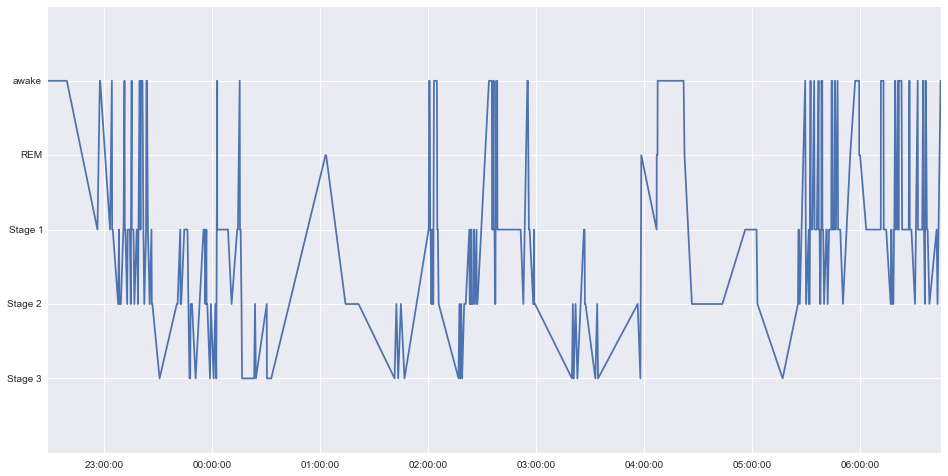

In [20]:
pp.plot(psg_stages['timestamp'], psg_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [24]:
# TODO: Add missing date points
psg_stages[psg_stages['timestamp'] > datetime(year=2016, month=6, day=21, hour=0, minute=30)]

timestamp  \
148 2016-06-21 00:30:18.000   
149 2016-06-21 00:30:24.410   
150 2016-06-21 00:30:40.900   
151 2016-06-21 00:32:48.000   
152 2016-06-21 01:02:56.390   
153 2016-06-21 01:03:17.170   
154 2016-06-21 01:03:18.000   
155 2016-06-21 01:14:03.520   
156 2016-06-21 01:14:32.220   
157 2016-06-21 01:14:33.900   
158 2016-06-21 01:21:18.000   
159 2016-06-21 01:41:18.000   
160 2016-06-21 01:42:18.000   
161 2016-06-21 01:43:18.000   
162 2016-06-21 01:44:48.000   
163 2016-06-21 01:46:48.000   
164 2016-06-21 02:00:10.250   
165 2016-06-21 02:00:11.300   
166 2016-06-21 02:00:18.000   
167 2016-06-21 02:00:29.030   
168 2016-06-21 02:00:47.400   
169 2016-06-21 02:00:48.000   
170 2016-06-21 02:01:04.510   
171 2016-06-21 02:01:18.000   
172 2016-06-21 02:01:40.330   
173 2016-06-21 02:01:42.220   
174 2016-06-21 02:01:48.000   
175 2016-06-21 02:02:18.000   
176 2016-06-21 02:02:25.720   
177 2016-06-21 02:02:27.430   
..                      ...   
395 2016-06-21 06:23:53.240   
396 2016-06-21 06:26:33.710   
397 2016-06-21 06:26:48.000   
398 2016-06-21 06:27:06.060   
399 2016-06-21 06:27:13.250   
400 2016-06-21 06:27:18.000   
401 2016-06-21 06:27:23.550   
402 2016-06-21 06:28:18.000   
403 2016-06-21 06:30:18.000   
404 2016-06-21 06:31:48.000   
405 2016-06-21 06:31:57.300   
406 2016-06-21 06:33:53.870   
407 2016-06-21 06:34:18.000   
408 2016-06-21 06:34:48.000   
409 2016-06-21 06:34:57.120   
410 2016-06-21 06:35:18.000   
411 2016-06-21 06:35:48.000   
412 2016-06-21 06:36:05.360   
413 2016-06-21 06:36:18.000   
414 2016-06-21 06:36:54.510   
415 2016-06-21 06:37:18.000   
416 2016-06-21 06:38:18.000   
417 2016-06-21 06:42:18.000   
418 2016-06-21 06:42:48.000   
419 2016-06-21 06:44:29.340   
420 2016-06-21 06:44:48.000   
421 2016-06-21 06:44:55.080   
422 2016-06-21 06:45:48.000   
423 2016-06-21 06:45:48.060   
424 2016-06-21 06:46:46.000   

                                                   raw  stage  
148                                         Stage - N2     -3  
149  Respiratory Event - Dur: 28.3 sec. - Hypopnea ...     -4  
150  * Desaturation - Dur: 52.0 sec. - Min 93.0 % -...     -4  
151                                         Stage - N3     -4  
152  Respiratory Event - Dur: 24.1 sec. - Hypopnea ...     -1  
153  Desaturation - Dur: 33.3 sec. - Min 92.0 % - D...     -1  
154                                          Stage - R     -1  
155  Respiratory Event - Dur: 16.9 sec. - Central A...     -3  
156       Arousal - Dur:  6.6 sec. - Respiratory Event     -3  
157                * Snore - Dur:  0.4 sec. - Isolated     -3  
158                                         Stage - N2     -3  
159                                         Stage - N3     -4  
160                                         Stage - N2     -3  
161                                         Stage - N3     -4  
162                                         Stage - N2     -3  
163                                         Stage - N3     -4  
164                     LM - Dur:  3.9 sec. - Periodic     -2  
165                     Arousal - Dur:  5.5 sec. - PLM     -2  
166                                         Stage - N1     -2  
167                     Arousal - Dur:  9.8 sec. - PLM      0  
168                     LM - Dur:  5.9 sec. - Periodic      0  
169                                          Stage - W      0  
170                     LM - Dur:  1.5 sec. - Periodic     -2  
171                                         Stage - N1     -2  
172                     Arousal - Dur:  6.2 sec. - PLM     -3  
173                     LM - Dur:  1.0 sec. - Periodic     -3  
174                                         Stage - N2     -3  
175                                         Stage - N1     -2  
176                     LM - Dur:  2.2 sec. - Periodic     -3  
177                     Arousal - Dur: 10.0 sec. - PLM     -3  
..                                                 ...    ...  
395                                  Position -

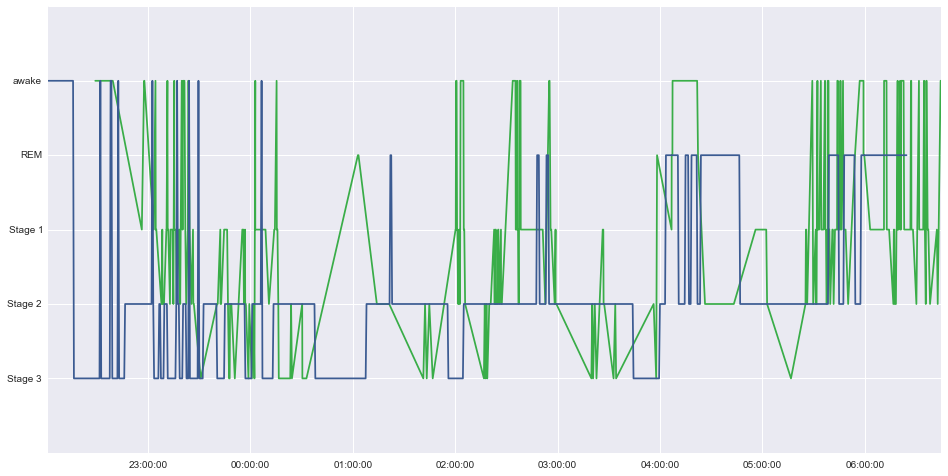

In [19]:
# finally, PSG / Neuroon

pp.plot(psg_stages['timestamp'], psg_stages['stage'], sns.xkcd_rgb['medium green'])
pp.plot(neuroon_stages['timestamp'], neuroon_stages['stage'], sns.xkcd_rgb['denim blue'] )
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

I will need to clean that up.

Special thanks to: Bartosz Król, Jarosław Hirniak, Adam Goliński